In [78]:
import re
from pathlib import Path 

import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image

In [43]:
def format_name(info):
    src = Path(info['video_src']).stem
    episode = re.search(r'S[0-9]{2}E[0-9]{2}', src).group(0)
    name = f'{episode}_{info["frame_num"]}_{info["face_num"]}.png'
    return name

In [68]:
df = pd.read_csv('./data/faces.csv', index_col=0)
df = df[['series_id', 
         'episode_id',
         'season',
         'episode',
         'frame_num',
         'face_num', 
         'x1', 
         'y1', 
         'x2',
         'y2',
         'img_height',
         'img_width',
         'area',
         'pct_of_frame',
         'encoding',
         'filename',
         'character',
         'cast_id',
         'cluster']]
df.head()

,series_id,episode_id,season,episode,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,encoding,filename,character,cast_id,cluster
0,1796960,1811020,1,1,192,0,798,196,916,314,1080,1920,13924,0.007,"[-0.1581144630908966, 0.11875572055578232, 0.0...",S01E01_192_0.png,NaN,NaN,-1.0
1,1796960,1811020,1,1,216,0,1068,389,1491,812,1080,1920,178929,0.086,"[-0.035924218595027924, 0.09460100531578064, 0...",S01E01_216_0.png,NaN,NaN,NaN
2,1796960,1811020,1,1,216,1,912,17,1205,311,1080,1920,86142,0.042,"[-0.10312943160533905, 0.1261938065290451, 0.0...",S01E01_216_1.png,NaN,NaN,NaN
3,1796960,1811020,1,1,240,0,1090,106,1384,400,1080,1920,86436,0.042,"[-0.18763160705566406, 0.08110883831977844, 0....",S01E01_240_0.png,NaN,NaN,NaN
4,1796960,1811020,1,1,240,1,674,522,968,816,1080,1920,86436,0.042,"[-0.11751651763916016, 0.1057925745844841, 0.0...",S01E01_240_1.png,NaN,NaN,NaN


In [54]:
episodes = pd.read_csv('./data/episodes.csv', index_col=0)
episodes.head()

,series_id,episode_id,title,year,season,episode,cast
0,1796960,1811020,Pilot,2011,1,1,"0000132,0507073,1072555,0362873,1459109,209313..."
1,1796960,1988308,Grace,2011,1,2,"0000132,0507073,1072555,0362873,1459109,209313..."
2,1796960,1988309,Clean Skin,2011,1,3,"0000132,0507073,1072555,0362873,1459109,209313..."
3,1796960,2011518,Semper I,2011,1,4,"0000132,0507073,1072555,0362873,1459109,209313..."
4,1796960,2023998,Blind Spot,2011,1,5,"0000132,0507073,1072555,0362873,1459109,209313..."


In [52]:
def get_faces(d):
    faces = list(sorted([x for x in d.iterdir()]))
    face_dfs = []
    for face in faces:
        face_df = pd.read_csv(str(face), index_col=0)
        episode = re.search(r'S[0-9]{2}E[0-9]{2}', face.stem).group(0)
        
        face_df['filename'] = face_df.apply(format_name, axis=1)
        face_df = face_df.drop('video_src', axis=1)
    
        s = int(episode[1:3])
        e = int(episode[4:6])
    
        face_df['season'] = s
        face_df['episode'] = e
        
        face_dfs.append(face_df)
        
    df = pd.concat(face_dfs, axis=0)
    df['series_id'] = int(d.parts[-1].split('_')[-1])
    return df

In [53]:
d = Path('./data/faces/house_2004_0412142')
face_df = get_faces(d)
face_df.head()

,img_height,img_width,face_num,x1,x2,y1,y2,area,pct_of_frame,frame_num,filename,season,episode,series_id
0,1080,1920,0,355,707,279,632,124256,0.060,192,S01E01_192_0.png,1,1,412142
1,1080,1920,0,734,1027,285,578,85849,0.041,216,S01E01_216_0.png,1,1,412142
2,1080,1920,1,71,213,154,296,20164,0.010,216,S01E01_216_1.png,1,1,412142
3,1080,1920,2,355,525,216,385,28730,0.014,216,S01E01_216_2.png,1,1,412142
4,1080,1920,0,640,992,208,560,123904,0.060,240,S01E01_240_0.png,1,1,412142


In [58]:
def join_episodes(face_df,
                  episode_df):
    df = face_df.merge(episode_df[['series_id', 'season', 'episode', 'episode_id']],
                       how='left',
                       on=['series_id', 'season', 'episode'])
    return df    

In [59]:
temp = join_episodes(face_df,
                     episode_df)
temp.head()

,img_height,img_width,face_num,x1,x2,y1,y2,area,pct_of_frame,frame_num,filename,season,episode,series_id,episode_id
0,1080,1920,0,355,707,279,632,124256,0.060,192,S01E01_192_0.png,1,1,412142,606035
1,1080,1920,0,734,1027,285,578,85849,0.041,216,S01E01_216_0.png,1,1,412142,606035
2,1080,1920,1,71,213,154,296,20164,0.010,216,S01E01_216_1.png,1,1,412142,606035
3,1080,1920,2,355,525,216,385,28730,0.014,216,S01E01_216_2.png,1,1,412142,606035
4,1080,1920,0,640,992,208,560,123904,0.060,240,S01E01_240_0.png,1,1,412142,606035


In [71]:
full_df = pd.concat([df, temp], axis=0)
full_df = full_df.reset_index(drop=True)
full_df.head()

,series_id,episode_id,season,episode,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,encoding,filename,character,cast_id,cluster
0,1796960,1811020,1,1,192,0,798,196,916,314,1080,1920,13924,0.007,"[-0.1581144630908966, 0.11875572055578232, 0.0...",S01E01_192_0.png,NaN,NaN,-1.0
1,1796960,1811020,1,1,216,0,1068,389,1491,812,1080,1920,178929,0.086,"[-0.035924218595027924, 0.09460100531578064, 0...",S01E01_216_0.png,NaN,NaN,NaN
2,1796960,1811020,1,1,216,1,912,17,1205,311,1080,1920,86142,0.042,"[-0.10312943160533905, 0.1261938065290451, 0.0...",S01E01_216_1.png,NaN,NaN,NaN
3,1796960,1811020,1,1,240,0,1090,106,1384,400,1080,1920,86436,0.042,"[-0.18763160705566406, 0.08110883831977844, 0....",S01E01_240_0.png,NaN,NaN,NaN
4,1796960,1811020,1,1,240,1,674,522,968,816,1080,1920,86436,0.042,"[-0.11751651763916016, 0.1057925745844841, 0.0...",S01E01_240_1.png,NaN,NaN,NaN


In [72]:
full_df.tail()

,series_id,episode_id,season,episode,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,encoding,filename,character,cast_id,cluster
712018,412142,2121965,8,22,60624,0,469,261,891,683,1080,1920,178084,0.086,NaN,S08E22_60624_0.png,NaN,NaN,NaN
712019,412142,2121965,8,22,60648,0,435,210,942,717,1080,1920,257049,0.124,NaN,S08E22_60648_0.png,NaN,NaN,NaN
712020,412142,2121965,8,22,60672,0,691,313,1198,820,1080,1920,257049,0.124,NaN,S08E22_60672_0.png,NaN,NaN,NaN
712021,412142,2121965,8,22,60696,0,537,313,1044,820,1080,1920,257049,0.124,NaN,S08E22_60696_0.png,NaN,NaN,NaN
712022,412142,2121965,8,22,60720,0,332,210,839,717,1080,1920,257049,0.124,NaN,S08E22_60720_0.png,NaN,NaN,NaN


In [73]:
full_df.to_csv('./data/faces.csv')

In [76]:
house_df = full_df[full_df['series_id'] == 412142]
house_df.head()

,series_id,episode_id,season,episode,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,encoding,filename,character,cast_id,cluster
249536,412142,606035,1,1,192,0,355,279,707,632,1080,1920,124256,0.060,NaN,S01E01_192_0.png,NaN,NaN,NaN
249537,412142,606035,1,1,216,0,734,285,1027,578,1080,1920,85849,0.041,NaN,S01E01_216_0.png,NaN,NaN,NaN
249538,412142,606035,1,1,216,1,71,154,213,296,1080,1920,20164,0.010,NaN,S01E01_216_1.png,NaN,NaN,NaN
249539,412142,606035,1,1,216,2,355,216,525,385,1080,1920,28730,0.014,NaN,S01E01_216_2.png,NaN,NaN,NaN
249540,412142,606035,1,1,240,0,640,208,992,560,1080,1920,123904,0.060,NaN,S01E01_240_0.png,NaN,NaN,NaN


In [85]:
exists = house_df[house_df['filename'].isin(files)]
exists

,series_id,episode_id,season,episode,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,encoding,filename,character,cast_id,cluster
249536,412142,606035,1,1,192,0,355,279,707,632,1080,1920,124256,0.060,NaN,S01E01_192_0.png,NaN,NaN,NaN
249537,412142,606035,1,1,216,0,734,285,1027,578,1080,1920,85849,0.041,NaN,S01E01_216_0.png,NaN,NaN,NaN
249538,412142,606035,1,1,216,1,71,154,213,296,1080,1920,20164,0.010,NaN,S01E01_216_1.png,NaN,NaN,NaN
249539,412142,606035,1,1,216,2,355,216,525,385,1080,1920,28730,0.014,NaN,S01E01_216_2.png,NaN,NaN,NaN
249540,412142,606035,1,1,240,0,640,208,992,560,1080,1920,123904,0.060,NaN,S01E01_240_0.png,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341657,412142,606039,2,13,61080,0,940,218,1362,640,1080,1920,178084,0.086,NaN,S02E13_61080_0.png,NaN,NaN,NaN
341658,412142,606039,2,13,61104,0,982,218,1405,640,1080,1920,178506,0.086,NaN,S02E13_61104_0.png,NaN,NaN,NaN
341659,412142,606039,2,13,61128,0,982,218,1405,640,1080,1920,178506,0.086,NaN,S02E13_61128_0.png,NaN,NaN,NaN
341660,412142,606039,2,13,61728,0,860,425,917,482,1080,1920,3249,0.002,NaN,S02E13_61728_0.png,NaN,NaN,NaN


In [98]:
top = exists.sort_values(by='area', ascending=False).iloc[:20]
top

,series_id,episode_id,season,episode,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,encoding,filename,character,cast_id,cluster
293663,412142,606013,1,18,960,0,254,0,1516,1080,1080,1920,1362960,0.657,NaN,S01E18_960_0.png,NaN,NaN,NaN
268190,412142,606036,1,8,16248,0,254,0,1516,1080,1080,1920,1362960,0.657,NaN,S01E08_16248_0.png,NaN,NaN,NaN
294475,412142,606013,1,18,20112,0,254,0,1516,1080,1080,1920,1362960,0.657,NaN,S01E18_20112_0.png,NaN,NaN,NaN
268191,412142,606036,1,8,16272,0,254,0,1516,1080,1080,1920,1362960,0.657,NaN,S01E08_16272_0.png,NaN,NaN,NaN
268192,412142,606036,1,8,16296,0,254,0,1516,1080,1080,1920,1362960,0.657,NaN,S01E08_16296_0.png,NaN,NaN,NaN
268193,412142,606036,1,8,16320,0,254,0,1516,1080,1080,1920,1362960,0.657,NaN,S01E08_16320_0.png,NaN,NaN,NaN
262134,412142,606045,1,6,288,0,509,0,1771,1080,1080,1920,1362960,0.657,NaN,S01E06_288_0.png,NaN,NaN,NaN
294476,412142,606013,1,18,20136,0,254,0,1516,1080,1080,1920,1362960,0.657,NaN,S01E18_20136_0.png,NaN,NaN,NaN
293664,412142,606013,1,18,1080,0,126,0,1388,1080,1080,1920,1362960,0.657,NaN,S01E18_1080_0.png,NaN,NaN,NaN
296492,412142,606028,1,19,5064,0,126,0,1388,989,1080,1920,1248118,0.602,NaN,S01E19_5064_0.png,NaN,NaN,NaN


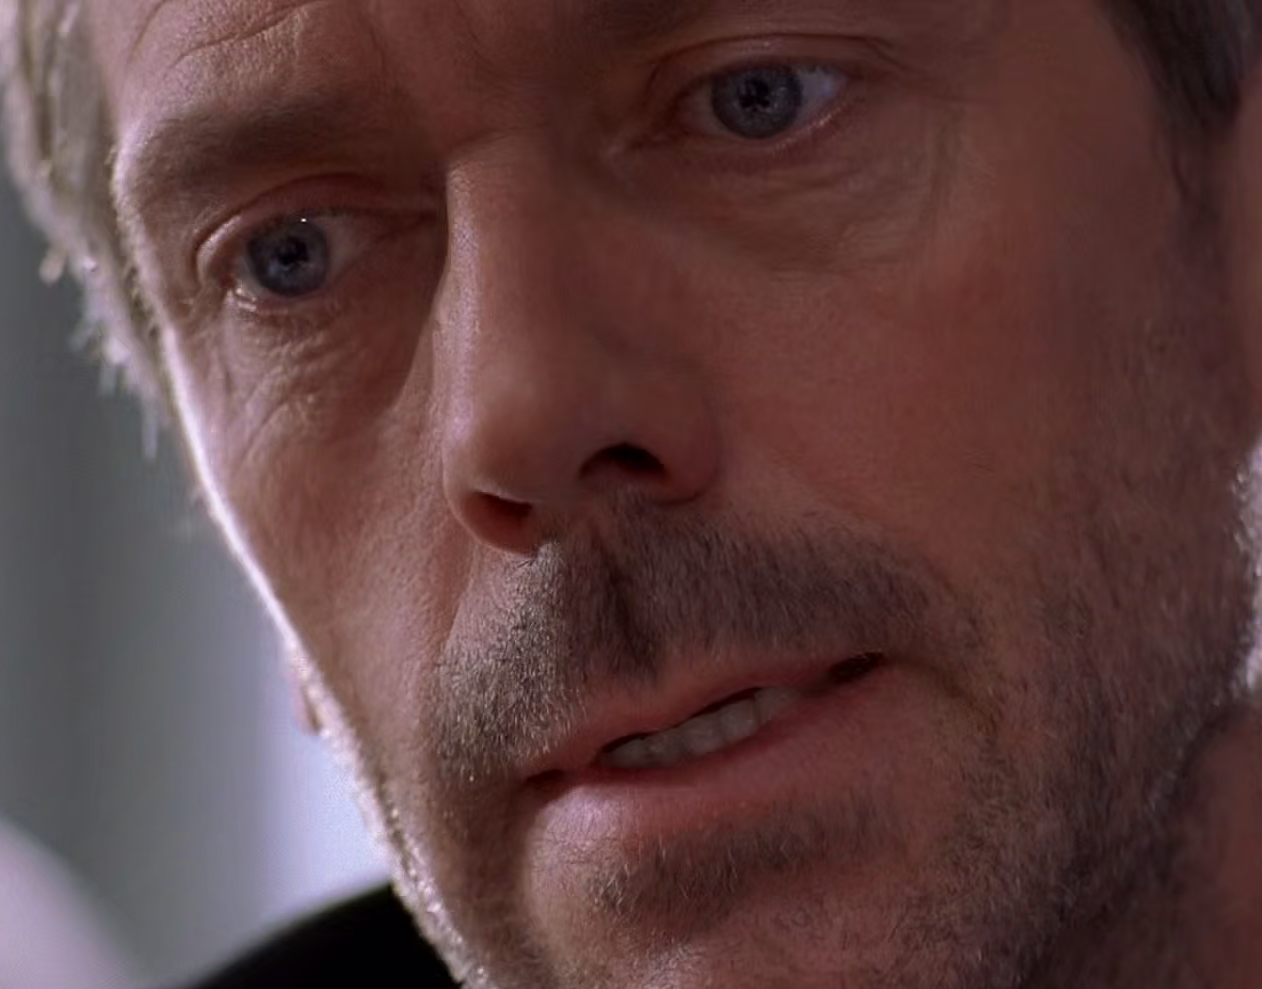

In [100]:
row = top.iloc[11]
dst = Path('./data/images/house_2004_0412142')
fp = dst.joinpath(row['filename'])
img = cv2.imread(str(fp))
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
Image.fromarray(rgb)

In [83]:
files = [x.name for x in Path('./data/images/house_2004_0412142').iterdir()]
files[0]

'S01E07_27096_1.png'

In [101]:
row

series_id                  412142
episode_id                 606044
season                          2
episode                         8
frame_num                    4848
face_num                        0
x1                            381
y1                              0
x2                           1643
y2                            989
img_height                   1080
img_width                    1920
area                      1248118
pct_of_frame                0.602
encoding                      NaN
filename        S02E08_4848_0.png
character                     NaN
cast_id                       NaN
cluster                       NaN
Name: 326000, dtype: object